In [26]:
import os
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import codecs

from nltk.corpus import stopwords
import stop_words
import pymorphy2
import re
import codecs

%matplotlib inline

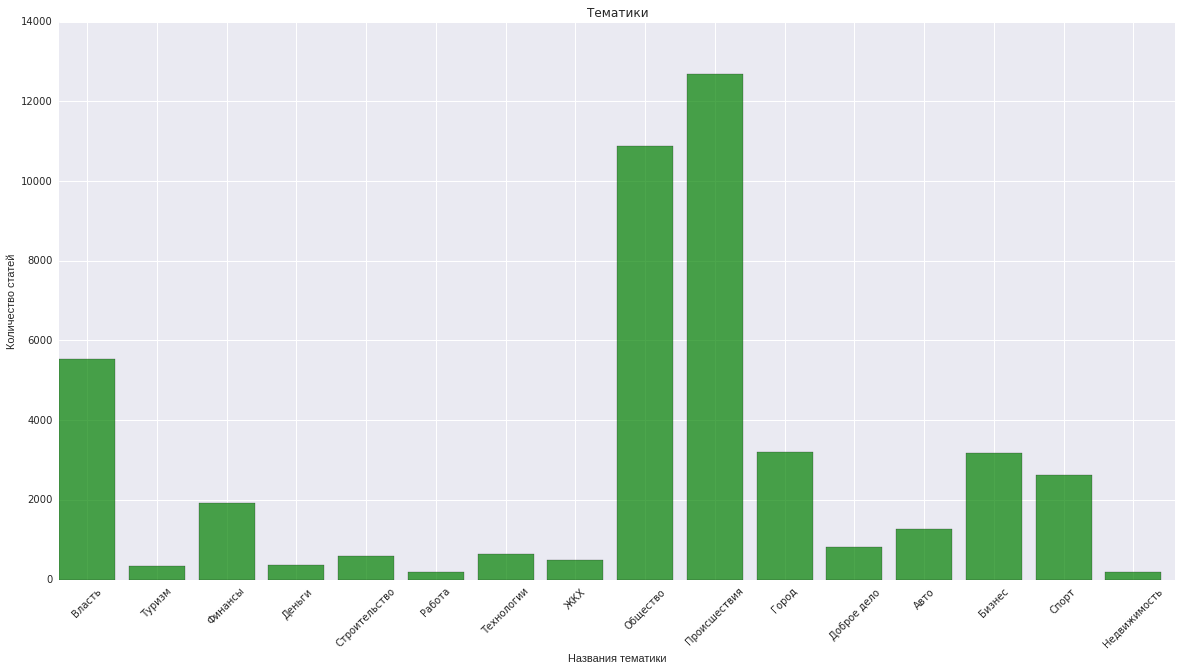

In [8]:
path_with_news = './all_news/'
ourTopics = {}
for d in os.listdir(path_with_news):
    ourTopics[d.decode('utf-8')] = len(os.listdir(path_with_news + d))
    
plt.figure(figsize=(20,10))
ind = np.arange(len(ourTopics.items()))
plt.bar(ind, ourTopics.values(), color='g', alpha = 0.7)

plt.title(u'Тематики')
plt.ylabel(u'Количество статей')
plt.xlabel(u'Названия тематики')
plt.xticks(ind + 0.4, tuple(ourTopics.keys()), rotation = 45)
pass

# Предобработка данных

Обработаем каждую из статей. Для каждой из статей возьмем текст и разобьем его по пробелу. Получим "слова", которые могут содержать знаки пунктуации, цифры. Выделим среди них "хорошие слова", которые будут характеризовать текст. Каждое "хорошее слово" приведем к нижнему регистру и найдем его лемму с помощью PyMorpy2. Также исключим стоп-слова (стоп слова взяти из пакетов nltk.stopwords и stop_words). Постараемся выделить аббревиатуры.

<br> <i> можно попробовать pymystem3 для лемматизации </i> 

Получим список стоп-слов. Зададим недопустимые знаки. Создадим морфологический анализатор.
Реализуем вспомогательные функции для обработки текстовой строки, обработки слова.

In [82]:

def getStopWords():
    mystopwords = set(stopwords.words("russian"))
    mystopwords = set.union(mystopwords, stop_words.get_stop_words('russian'))
    return mystopwords

def relax_word(word, prev_word = None):
    """Обработка слова. Приведение к нормальному виду"""
        
    # Удаление слов, в которых есть цифры (лучше считать отношение количества цифр к количеству букв)
    if re.search(r'\d', word):
        return None
    
    # Удаление знаков препинания и других символов с обеих концов строки
    word = word.strip(forStrip)
    
    if re.search(bad_symbols, word):
        return None
    
    # выделение аббревиатур
    if word.isupper() and len(word) > 1 and len(word) < 7:
        if word.lower() in stops:
            return None
        return word.lower()
    
    if len(word) < 3:
        return None
    
    # Приведение к нижнему регистру
    word = word.lower()
    
    # Удаление стоп-слов
   
    if word in stops:
        return None
        
    # Лемматизация с помощью pymorpy2
    word = morph.parse(word)[0].normal_form
    
    # на всякий случай - если было слово мое, то в нормальной форме мой. Нужно удалить.
    if word in stops:
        return None
    
    return word

def prepocess(text):
    """ Функция получает строку текста и делает его преодработку """
    text = text.split()
    result = []
    for word in text:
        word = relax_word(word)
        if word:
            result.append(word)
    return " ".join(result)
    
stops = list(getStopWords()) + [u'i', u'ii', u'iii', u'iv', u'v', u'vi', u'vii', u'viii', u'ix', u'x', u'xi', \
                         u'xii', u'xiii', u'xiv', u'xv', u'xvi', u'xvii', u'xviii', u'xix', u'xx']
forStrip = "".join(['.',',','!','?','"',"'",';',':','-',u'«',u'»',u'(',u')',u'{',u'}',u'[',u']',u'…',u'/',u'—'])
morph = pymorphy2.MorphAnalyzer() 
bad_symbols = u'[@%_\.$+/*:^&#]'

Рассмотрим пример обработки строки: **В 10:32 на пульт дежурного "01" поступило сообщение о ДТП в Красногвардейском районе, сообщает сайт ГУ МЧС по Петербургу. Читатель "Фонтанки" между тем сообщил, что на углу проспектов Ударников и Индустриального лежит перевернутый автобус.**

In [73]:
test_string = u"""В 10:32 на пульт дежурного "01" поступило сообщение о ДТП в Красногвардейском районе, 
сообщает сайт ГУ МЧС по Петербургу. Читатель "Фонтанки" между мой
тем сообщил, что на углу проспектов Ударников и IV Индустриального лежит мое перевернутый автобус."""

print prepocess(test_string)



пульт дежурный поступить сообщение дтп красногвардейский район сообщать сайт гу мчс петербург читатель фонтанка сообщить угол проспект ударник индустриальный лежать перевернуть автобус


###Предобработка всей коллекции

In [79]:
news_path = "./all_news/"
preprocessedNews_path = "./preprocessedNews/"

news_category = os.listdir(news_path)
for nc in os.listdir(news_path):
    try:
        os.mkdir(preprocessedNews_path + nc)
    except:
        pass
    
for newsCat in os.listdir(news_path):
    print "Processed: %s\n"%newsCat
    for article in os.listdir(news_path + newsCat):
        with codecs.open(preprocessedNews_path + newsCat + '/' + article, 'w', 'utf8') as ouf:
            with codecs.open(news_path + newsCat + '/' + article, 'r', 'utf8') as inf:
                for line in inf:
                    if len(line) > 3:
                        ouf.write("%s "%prepocess(line))

Processed: Власть

Processed: Технологии

Processed: Происшествия

Processed: Строительство

Processed: Деньги

Processed: Работа

Processed: Недвижимость

Processed: Туризм

Processed: ЖКХ

Processed: Общество

Processed: Авто

Processed: Финансы

Processed: Спорт

Processed: Город

Processed: Бизнес

Processed: Доброе дело



## Исправление ошибок в preprocessedNews
1. Удаление слов, которые присутствуют во всех тематиках
2. <s> В некоторых словах пристутсвуют запрещенные символы </s>
3. Есть иностранные слова ???


####сбор статистики о словах

 1. Для каждого слова посчитать сколько раз в каких темах оно встречается

In [232]:
from collections import defaultdict

class Voca_statistic(object):
    def __init__(self, cat_path):
        self.category = [s.decode('utf8') for s in os.listdir(cat_path)] + [u'Итого']
        self.voc = defaultdict(lambda: defaultdict(lambda : 0))
        self.ids = defaultdict(lambda: 0)
        self.cur_id = 0
    def add(self, words, categ):
        categ = categ.decode('utf8')
        for w in words:
            self.voc[w][categ] += 1
            self.voc[w][self.category[-1]] += 1
            if self.ids[w] == 0:
                self.ids[w] = self.cur_id
                self.cur_id += 1
    
    def save(self, path = "VocaStat.csv"):
        with codecs.open(path, 'w', 'utf8') as ouf:
            s = ("word\tid\t%s\n"%(u'\t'.join(self.category)))
            ouf.write(s)
            
            
            for k in self.voc.keys():
                cat_stat = u"\t".join([(str(self.voc[k][cat])).decode('utf8') for cat in self.category])
                ouf.write(u"%s\t%d\t%s\n"%(k,self.ids[k],cat_stat))



In [233]:
path = "./preprocessedNews/"

voca = Voca_statistic(path)

for category in os.listdir(path):
    print category, 
    for article in os.listdir(path + category):
        with codecs.open(path + category + "/" + article, 'r', 'utf8') as inf:
            for line in inf:
                voca.add(line.split(),category)
voca.save()

Власть Технологии Происшествия Строительство Деньги Работа Недвижимость Туризм ЖКХ Общество Авто Финансы Спорт Город Бизнес Доброе дело


In [237]:
import pandas as pd
df = pd.read_csv("VocaStat.csv", sep='\t',encoding='utf8')

In [235]:
def make_plot(values, words, topic, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    ind = np.arange(len(words))
    plt.bar(ind, values, color='g', alpha = 0.7)

    plt.title(topic)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.xticks(ind + 0.4, tuple(words), rotation = 45)
    plt.show()

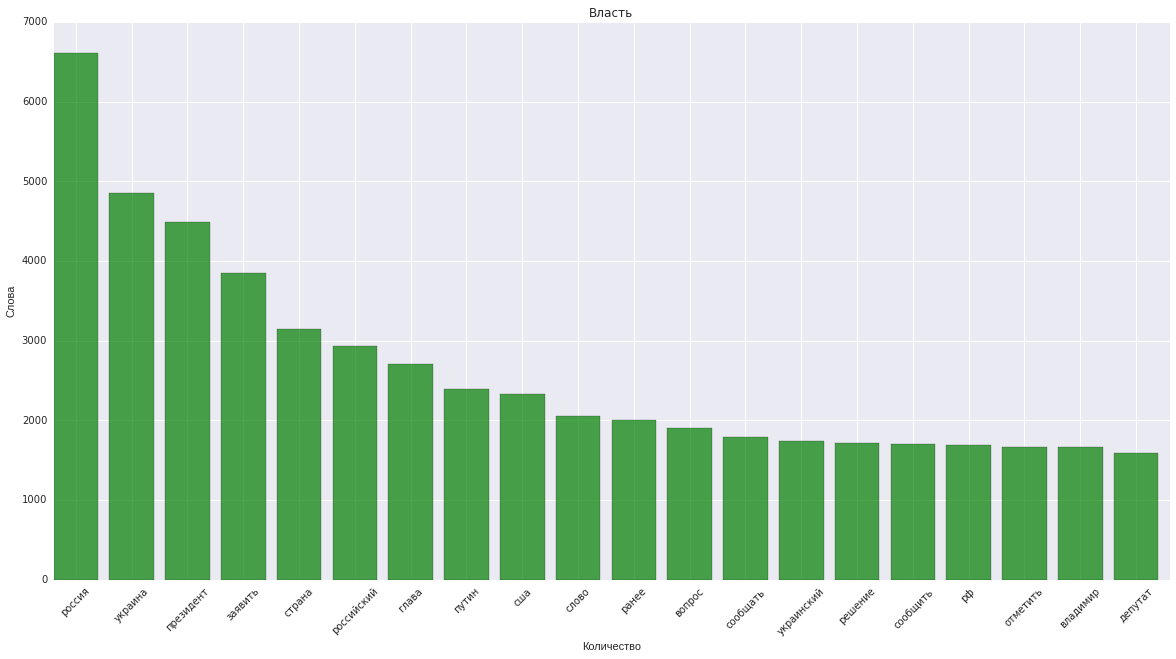

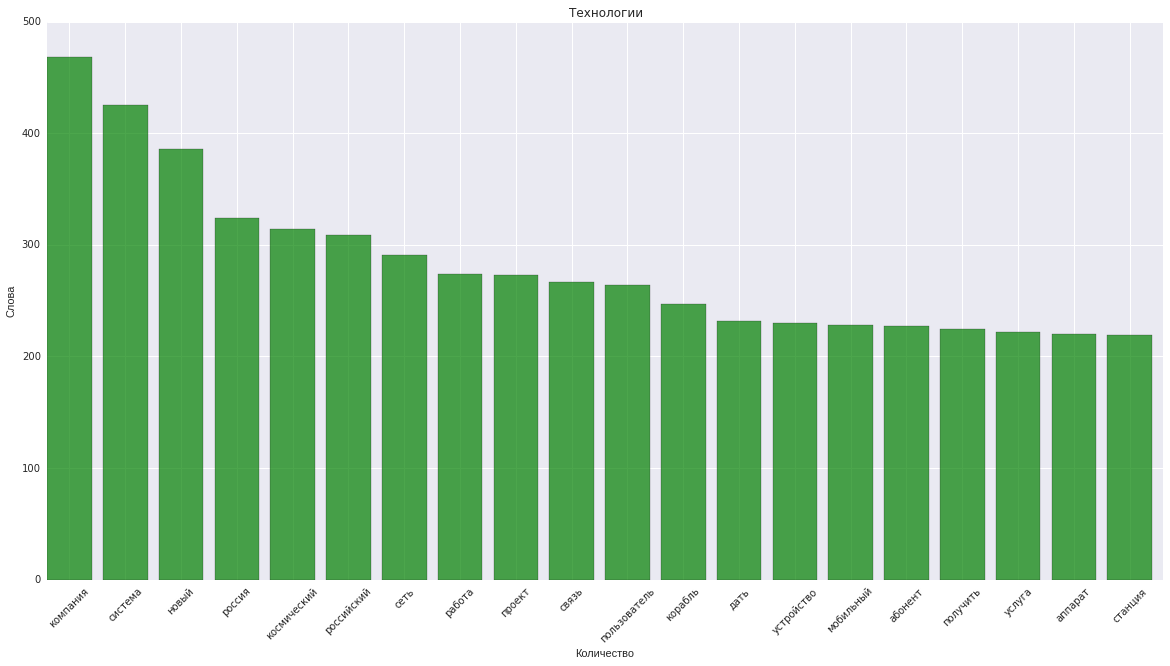

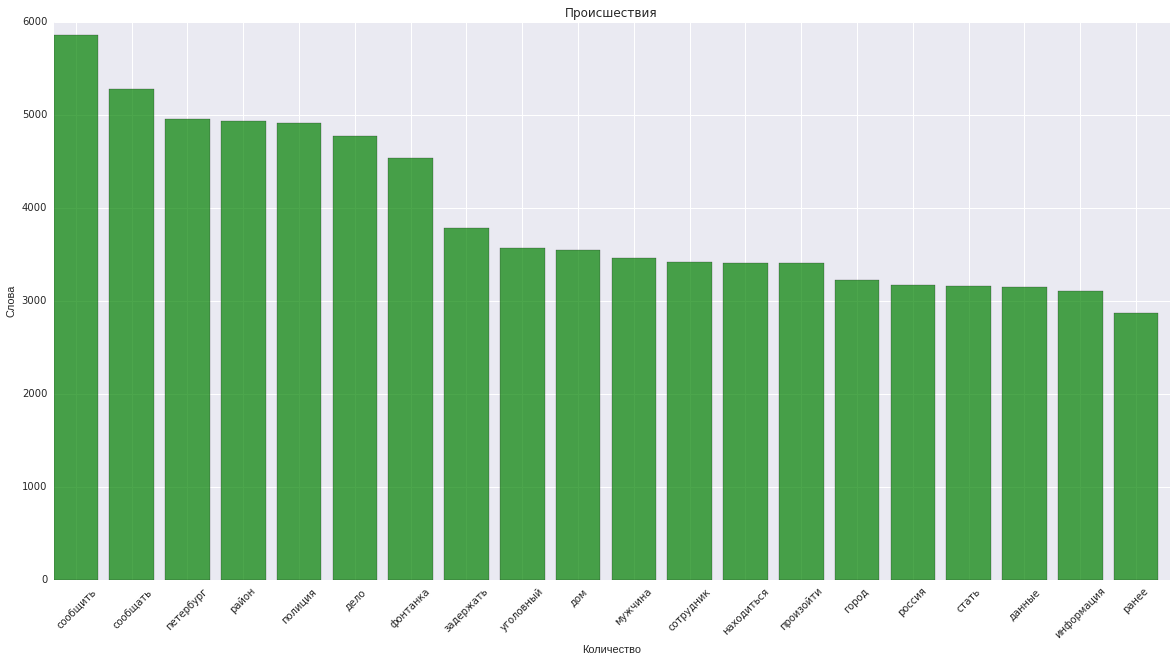

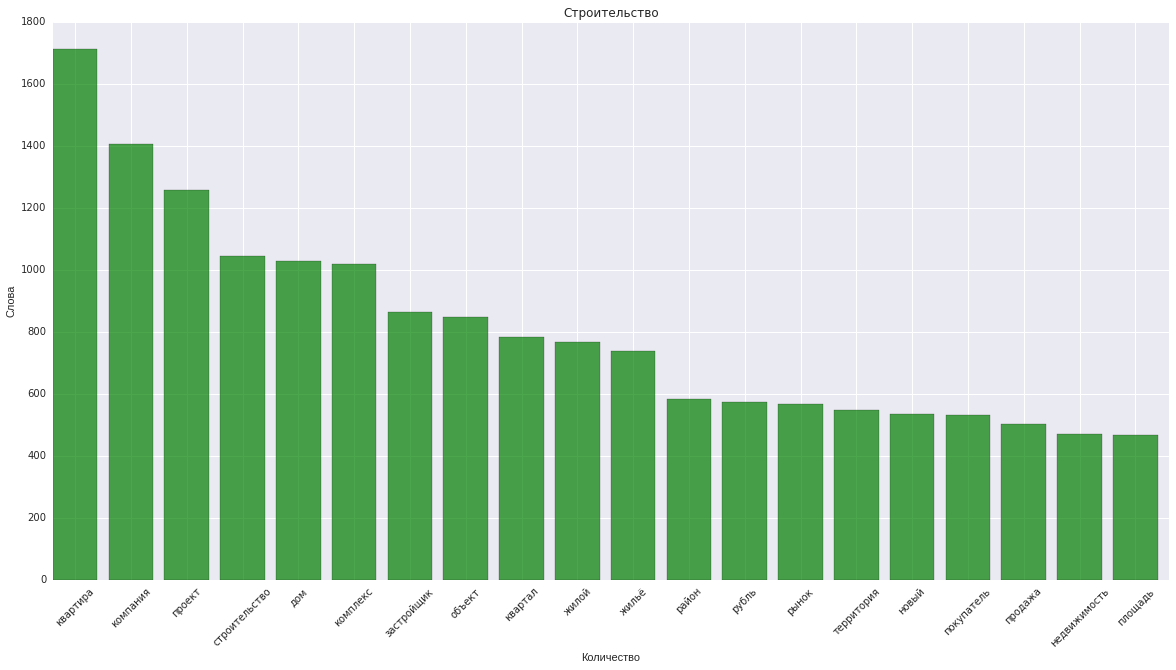

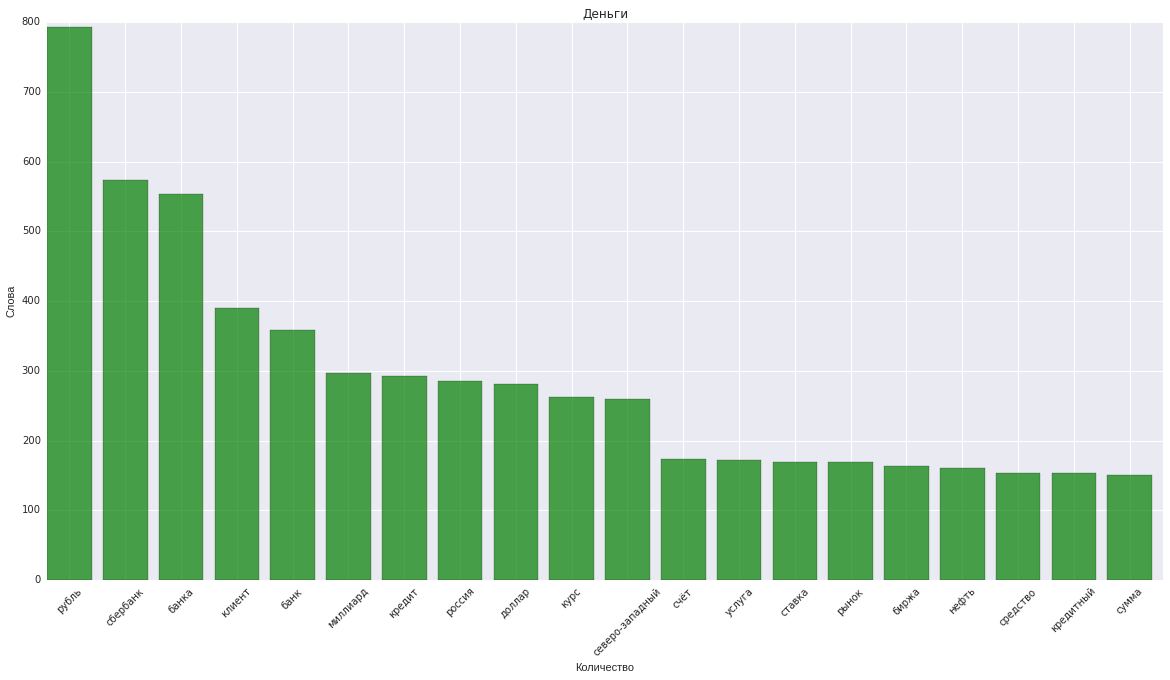

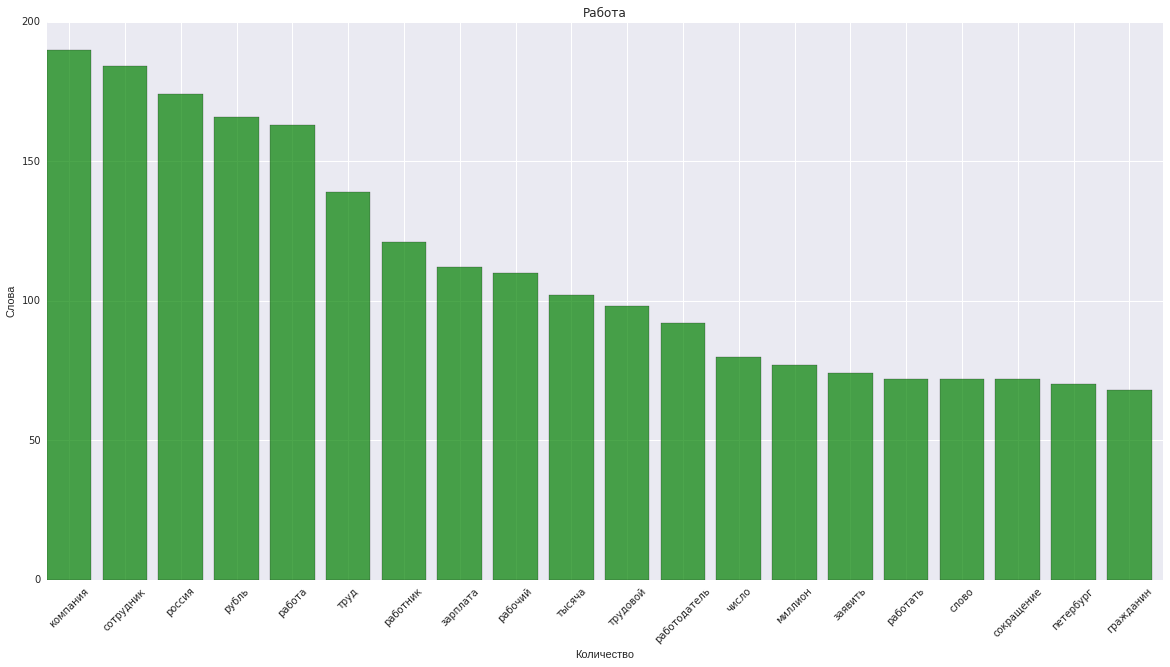

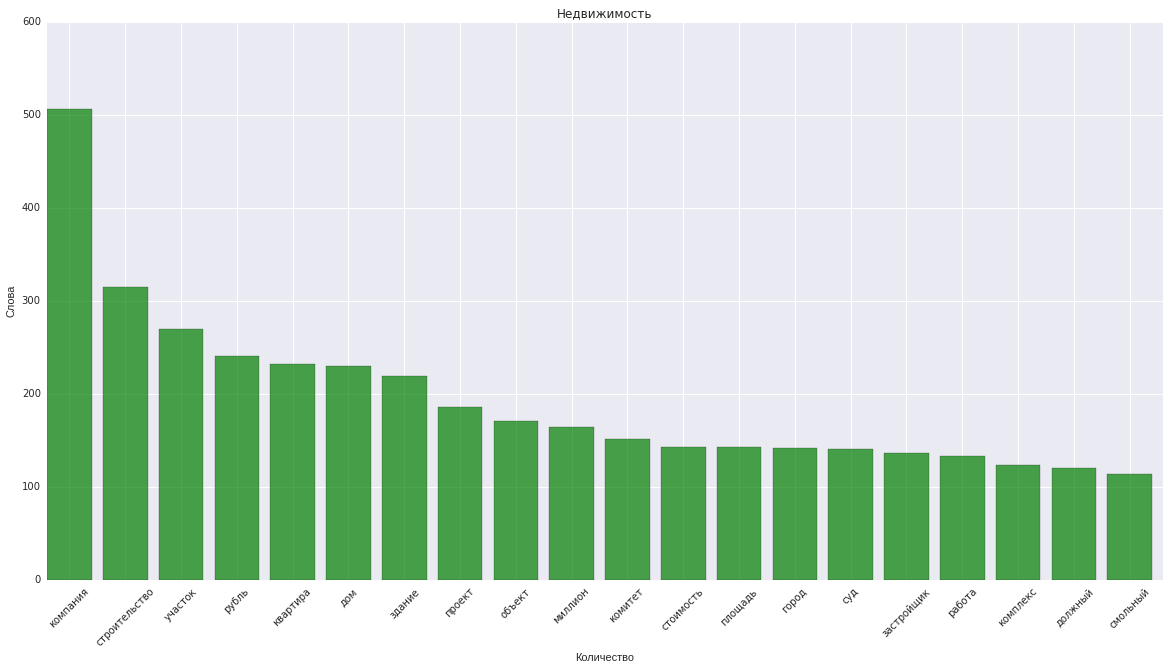

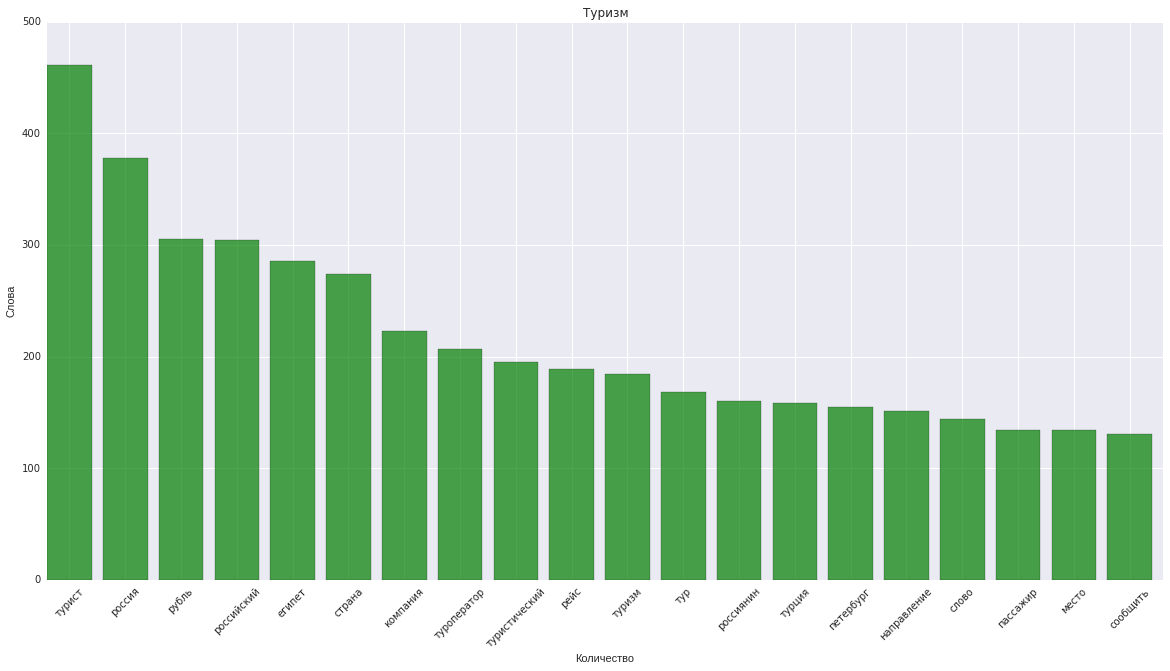

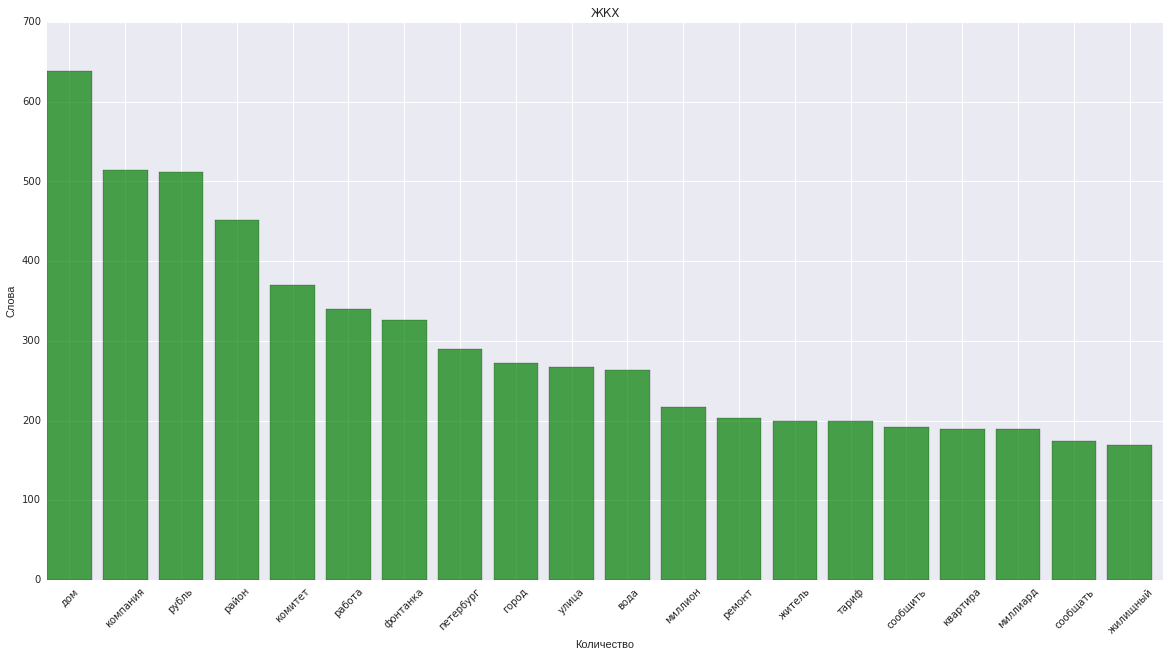

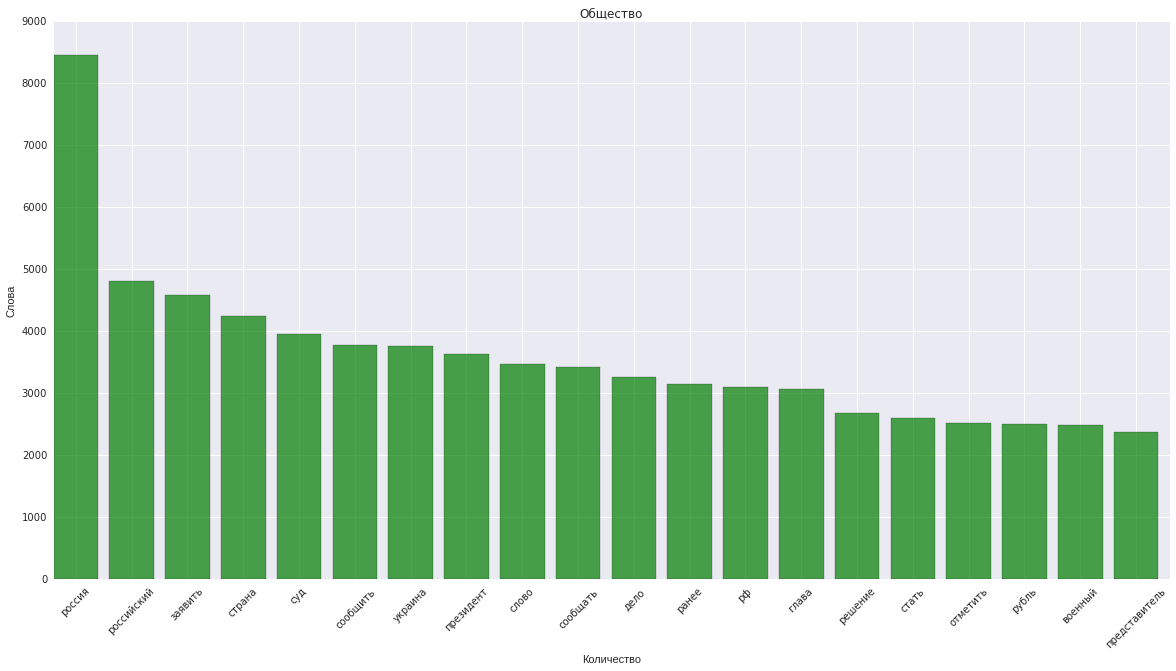

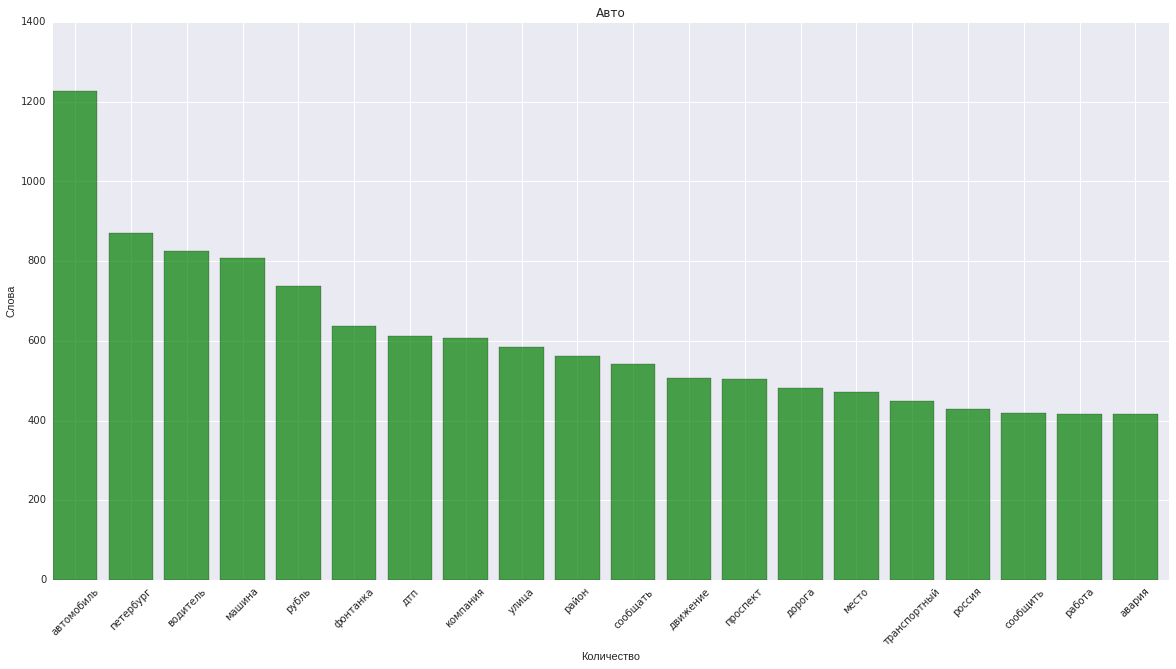

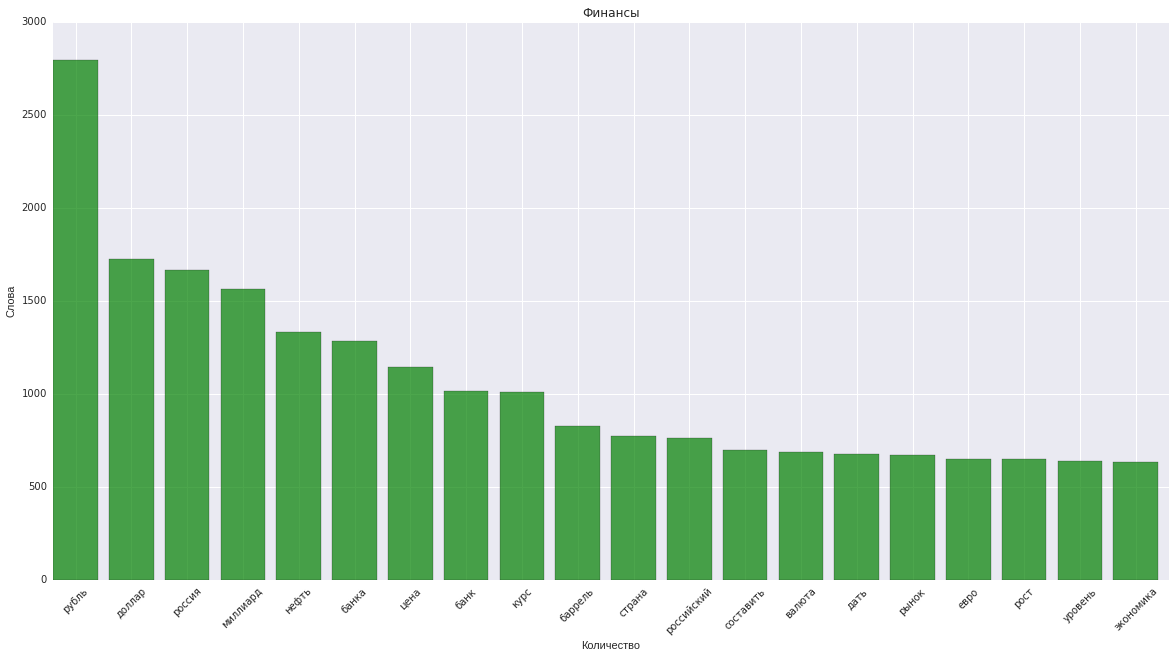

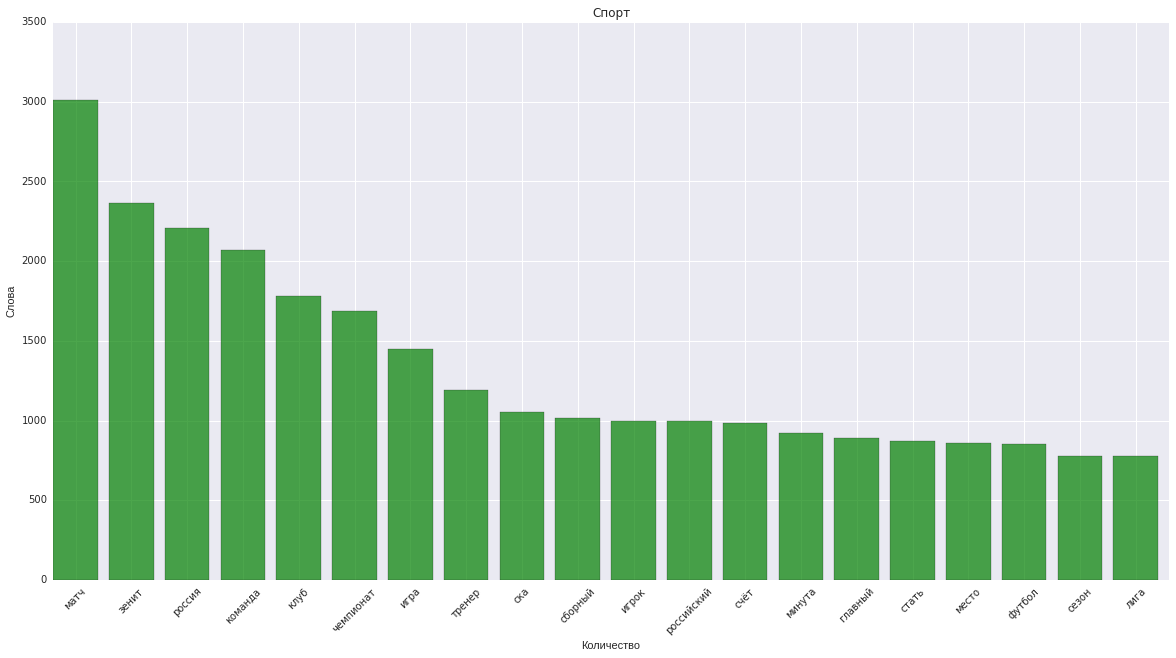

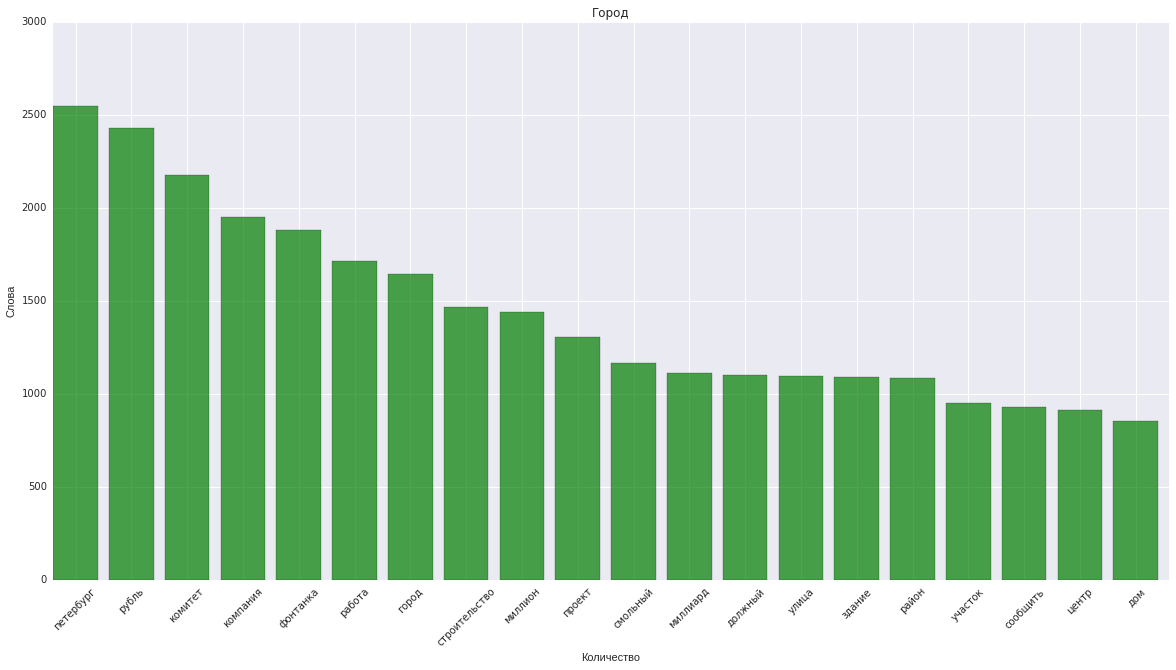

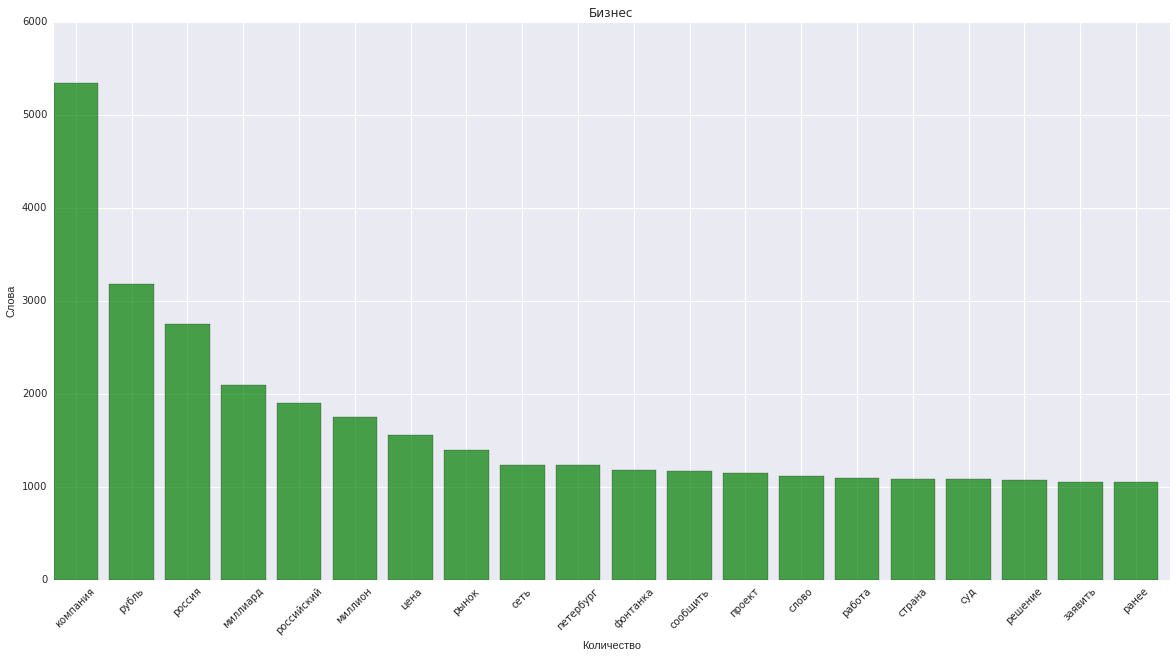

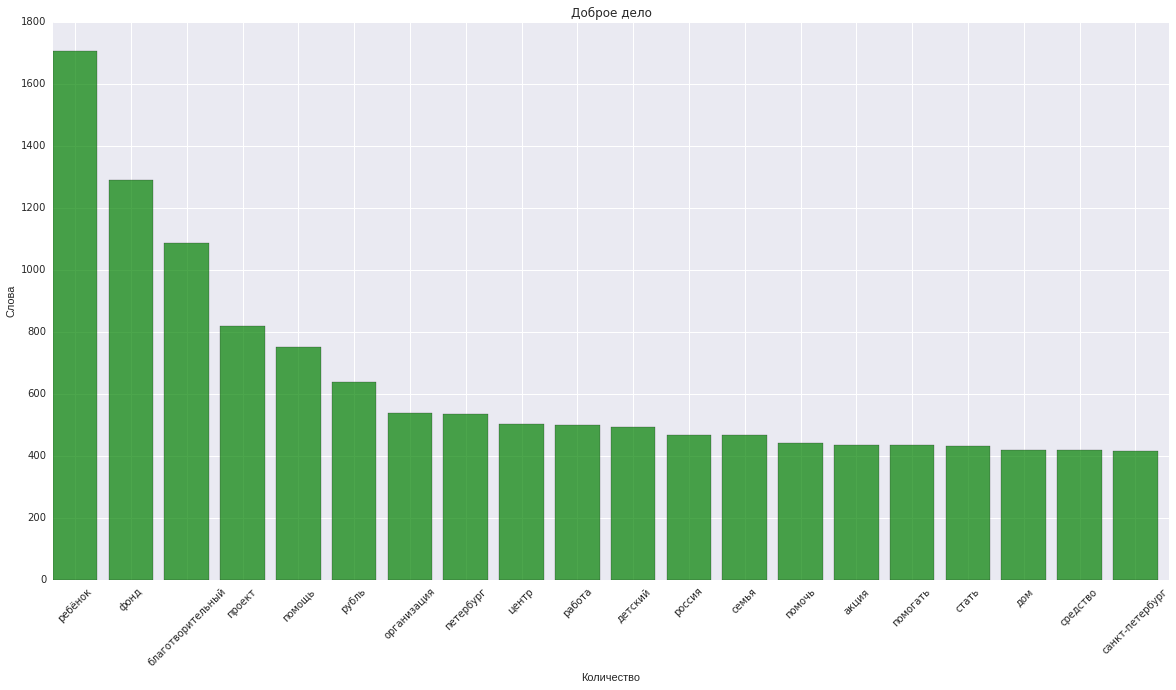

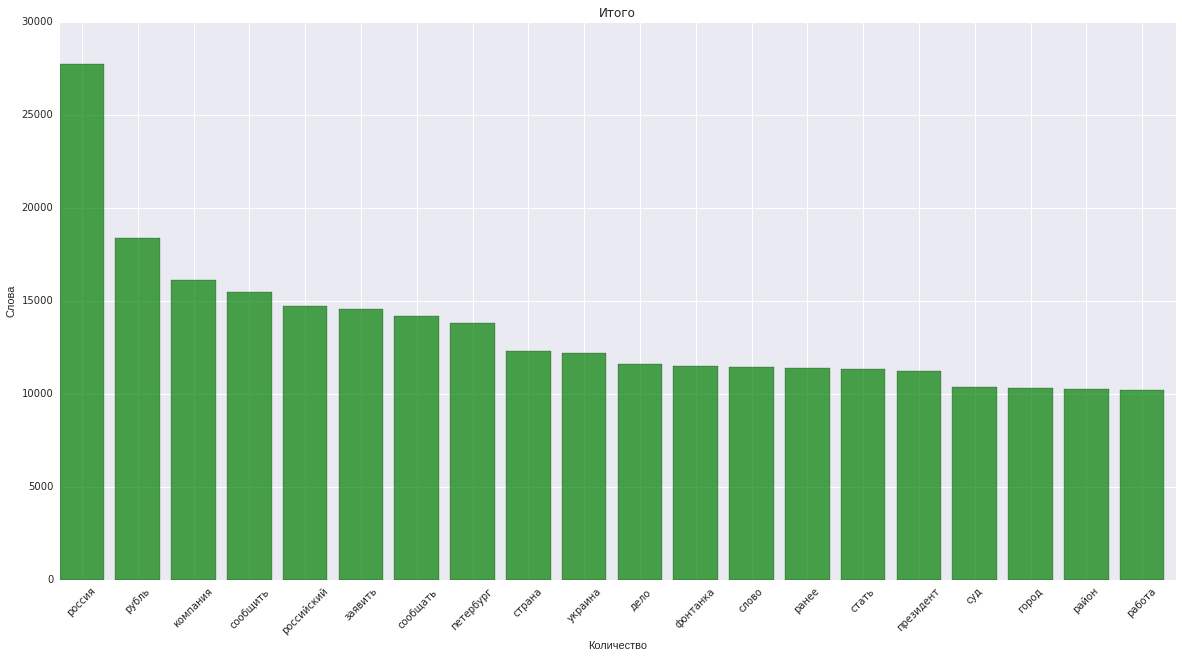

In [236]:
for column in df.columns[2:]:
    df_plt = df[[u'word', column]].sort(column, ascending=False)[:20]
    words = list(df_plt.word)
    values = list(df_plt[column])
    make_plot(values, words, column, u'Слова', u'Количество')
    
    
